# Project 1 Part 2: Classifying Names with a Character-Level RNN

Use RNN model generate Names from language:

```bash
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov
```

## 数据处理 data preprocessing

In [8]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)

def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD",s) if unicodedata.category(c) != 'Mn' and c in all_letters)

def readLines(filename):
    with open(filename, encoding="utf-8") as some_file:
        return  [unicodeToAscii(line.strip()) for line in some_file]
    
# Build the category_lines dictionary, a list of lines per category
# 类字典，一个类别有多个line
category_lines = {}
all_categories = []
for filename in findFiles('/harddisk1/SZC-Project/NLP-learning/RNNs/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError("Data not found. Make sure that you downloaded data "
        "from https://download.pytorch.org/tutorial/data.zip and extract it to "
        "the current directory.")

print("# categories:", n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Russian', 'Arabic', 'German', 'Portuguese', 'Scottish', 'Spanish', 'Korean', 'Italian', 'Greek', 'Czech', 'Vietnamese', 'Japanese', 'French', 'Chinese', 'Polish', 'English', 'Dutch', 'Irish']
O'Neal


## 创建网络 create the network

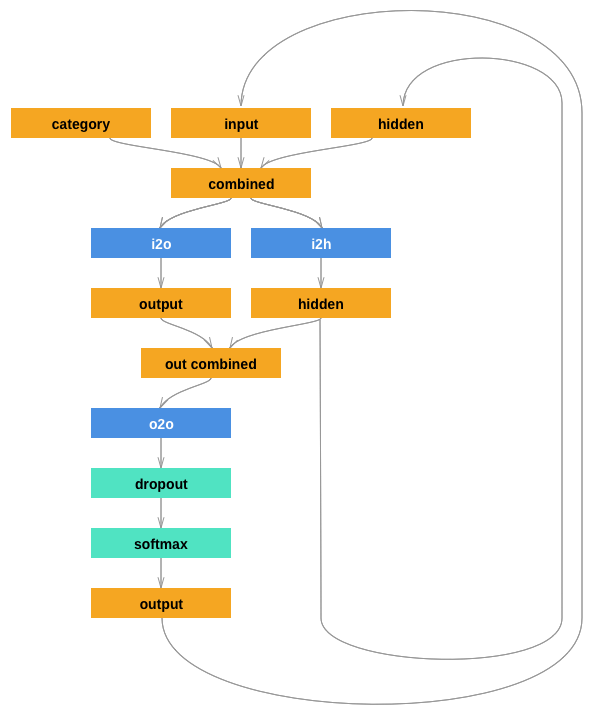

网络结构如上所示

- 相比于part1中的RNN结构，增加了category的输入（将category与input，hidden结合）
- 在out combined层后增加了o2o 层，最终output作为input
- hidden层全局共享
- 是一个many-to-many rnn

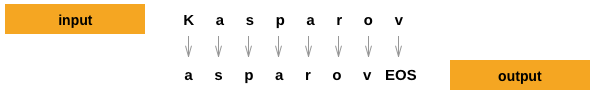

- 每一个时间step，即在训练时每一个input letter, 输入都是`(category, current letter, hidden state)`, 之后输出就是 `(next letter, next hidden state)`
- 对于每一个train set， 我们需要`the category, a set of input letters, and a set of output/target letters`
- 因为任务本质上是在预测下一个letter，而名字内部letter的上下文关系是连续的，例如`for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).`
### 数学代码解释

In [9]:
import torch
import torch.nn as nn

# 注释

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


## Training 训练网络
### Preparing for training 训练前准备
- 首先，准备函数：得到随机的(category, line)
- 需要获取训练时用得到的`category_tensor, input_line_tensor, target_line_tensor`

In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.index(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.index(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters-1)
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [11]:
all_categories

['Russian',
 'Arabic',
 'German',
 'Portuguese',
 'Scottish',
 'Spanish',
 'Korean',
 'Italian',
 'Greek',
 'Czech',
 'Vietnamese',
 'Japanese',
 'French',
 'Chinese',
 'Polish',
 'English',
 'Dutch',
 'Irish']

In [12]:
categoryTensor('Russian')

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
randomTrainingPair()

('Irish', 'Cleirigh')

In [14]:
inputTensor('Cleirigh')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0

In [15]:
targetTensor('Cleirigh')

tensor([11,  4,  8, 17,  8,  6,  7, 57])

In [17]:
randomTrainingExample()

(tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

### Training the network 进行一次line训练的基础train function

In [22]:
import time
import math

criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    # you can also just simply use ``loss = 0``
    loss = torch.Tensor([0]) 

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item() / input_line_tensor.size(0)

# keep track of how long training takes
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m*60
    return '%dm %ds' % (m, s)

# 正式开始训练
# 因为是一个预测下一个字符是什么，所以就output_size = input_size
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 4s (5000 5%) 3.0037
0m 9s (10000 10%) 2.0097
0m 14s (15000 15%) 3.1364
0m 19s (20000 20%) 1.6968
0m 23s (25000 25%) 2.6290
0m 28s (30000 30%) 2.0590
0m 33s (35000 35%) 2.1073
0m 38s (40000 40%) 2.4258
0m 42s (45000 45%) 2.1663
0m 47s (50000 50%) 3.4147
0m 52s (55000 55%) 3.1917
0m 57s (60000 60%) 2.2258
1m 1s (65000 65%) 2.0614
1m 6s (70000 70%) 2.3483
1m 11s (75000 75%) 2.6339
1m 16s (80000 80%) 2.6310
1m 20s (85000 85%) 1.0295
1m 25s (90000 90%) 2.9439
1m 30s (95000 95%) 2.3582
1m 35s (100000 100%) 2.2715


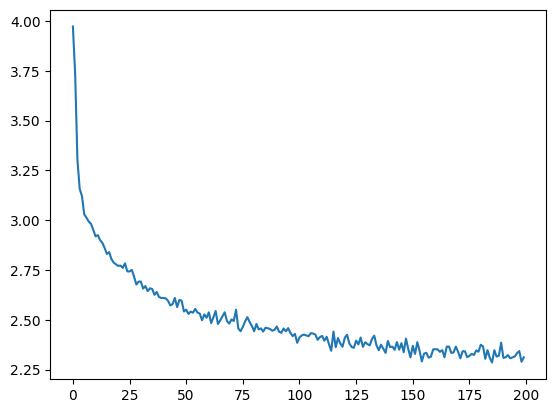

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## sampling the network

In [26]:
max_length = 20

# sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [28]:
samples("Russian","RUSIAN")

Rovanovev
Uarinov
Sharavev
Iantovov
Allanov
Nakin


In [29]:
samples("Chinese", "SONG")

Shan
Oun
Nan
Guan


In [30]:
samples("Japanese","Nako")

Namara
araka
kamama
outa


In [31]:
samples('Spanish', 'SPA')

Santa
Parer
Allan


In [32]:
samples('English', 'Spanish')

Santon
panter
arter
nomer
iller
santer
hallen
